In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier  # Fixed typo: "DecisionTreeClassifie"

from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical  # Fixed import path
from tensorflow.keras.layers import LSTM, MaxPooling2D, Dense, Dropout, Activation, Flatten, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Convolution2D #load CNN model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [6]:
#define minmax object for features normalization
scaler = MinMaxScaler(feature_range = (0, 1)) #use to normalize training data

In [7]:
#load and display dataset values
dataset = pd.read_csv("Dataset/hpc_io_data.csv")
dataset.fillna(0, inplace = True)#replace missing values
dataset

,instructions,LLC-stores,L1-icache-load-misses,branch-load-misses,node-load-misses,rd_req,rd_bytes,wr_req,wr_bytes,flush_operations,rd_total_times,wr_total_times,flush_total_times,label
0,77556160.0,9575.0,257517.0,215949.0,0.0,0,0,8,147456,4,0,3596349,4524778,1
1,32981037.0,16800.0,797990.0,140417.0,2.0,0,0,0,0,0,0,0,0,1
2,11049222.0,5302.0,204689.0,55819.0,0.0,0,0,0,0,0,0,0,0,1
3,4968323.0,5252.0,188982.0,34310.0,0.0,0,0,0,0,0,0,0,0,1
4,15314480.0,11345.0,601098.0,112428.0,0.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,58694891.0,1827.0,9147.0,468151.0,0.0,0,0,0,0,0,0,0,0,0
5996,51471771.0,863.0,3740.0,521066.0,0.0,0,0,0,0,0,0,0,0,0
5997,49304168.0,5280.0,12560.0,480046.0,0.0,0,0,2,28672,1,0,503895,2094439,0
5998,55666764.0,13175.0,53589.0,529373.0,0.0,0,0,0,0,0,0,0,0,0


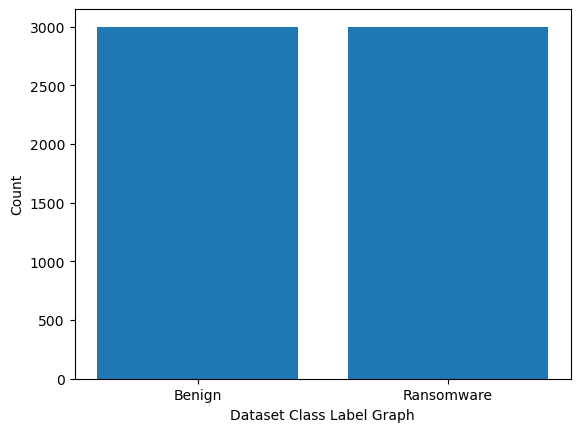

In [24]:
#find and plot graph of ransomware and benign from dataset where 0 label refers as benign and 1 refer as ransomware
#plot labels in dataset
labels, count = np.unique(dataset['label'], return_counts = True)
labels = ['Benign', 'Ransomware']
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [79]:
#dataset preprocessing such as normalization and shuffling
#data = dataset.values
#X = data[:,1:data.shape[1]-1]
#Y = data[:,data.shape[1]-1]
#Y = Y.astype(int)

#indices = np.arange(X.shape[0])
#np.random.shuffle(indices)#shuffle dataset values
#X = X[indices]
#Y = Y[indices]

#scaler = MinMaxScaler((0,1))
#X = scaler.fit_transform(X)#normalized or transform features
#print("Normalized Features")
#print(X)

In [8]:
dataset.columns

Index(['instructions', 'LLC-stores', 'L1-icache-load-misses',
       'branch-load-misses', 'node-load-misses', 'rd_req', 'rd_bytes',
       'wr_req', 'wr_bytes', 'flush_operations', 'rd_total_times',
       'wr_total_times', 'flush_total_times', 'label'],
      dtype='object')

In [9]:
X = dataset[['instructions', 'LLC-stores', 'L1-icache-load-misses',
       'branch-load-misses', 'node-load-misses', 'rd_req', 'rd_bytes',
       'wr_req', 'wr_bytes', 'flush_operations', 'rd_total_times',
       'wr_total_times', 'flush_total_times']]
Y = dataset['label']

In [10]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 4800
Testing Size (20%): 1200



In [11]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

ML_Model = []
acc = []
prec = []
rec = []
f1 = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    acc.append(round(a, 3))
    prec.append(round(b, 3))
    rec.append(round(c, 3))
    f1.append(round(d, 3))

In [28]:
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict, average='macro') * 100
    r = recall_score(testY, predict, average='macro') * 100
    f = f1_score(testY, predict, average='macro') * 100
    a = accuracy_score(testY, predict) * 100     

    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision : '+str(p))
    print(algorithm+' Recall    : '+str(r))
    print(algorithm+' F1 Score  : '+str(f))    

    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)

    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize=(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", fmt="g")
    ax.set_ylim([0, len(labels)])
    plt.title(algorithm + " Confusion Matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


# SVM


SVM Accuracy  : 59.25
SVM Precision : 75.97579807769111
SVM Recall    : 60.85913043478261
SVM F1 Score  : 53.150112054904106


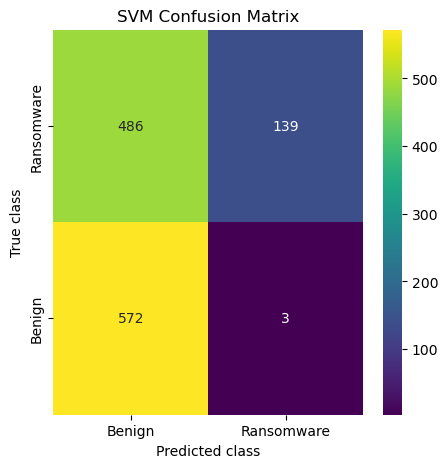

In [56]:
#now train SVM algorithm on training features and then test on testing features to calculate accuracy and other metrics
svm_cls = svm.SVC(kernel="poly", gamma="scale", C=0.004)
svm_cls.fit(X_train, y_train)
predict = svm_cls.predict(X_test)
calculateMetrics("SVM", predict, y_test)

In [57]:
svm_acc = accuracy_score(predict, y_test)
svm_prec = precision_score(predict, y_test,average='macro')
svm_rec = recall_score(predict, y_test,average='macro')
svm_f1 = f1_score(predict, y_test,average='macro')

storeResults('SVM',svm_acc,svm_prec,svm_rec,svm_f1)

# KNN


KNN Accuracy  : 90.75
KNN Precision : 90.77491082441578
KNN Recall    : 90.84173913043479
KNN F1 Score  : 90.74768049490186


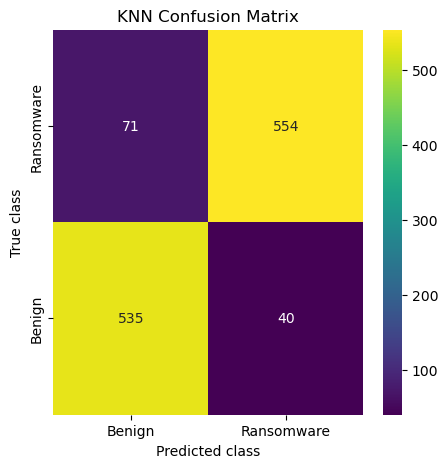

In [58]:
#now training KNN algorithm
knn_cls =  KNeighborsClassifier(n_neighbors=500)
knn_cls.fit(X_train, y_train)
predict = knn_cls.predict(X_test)
calculateMetrics("KNN", predict, y_test)

In [33]:
knn_acc = accuracy_score(predict, y_test)
knn_prec = precision_score(predict, y_test,average='macro')
knn_rec = recall_score(predict, y_test,average='macro')
knn_f1 = f1_score(predict, y_test,average='macro')

storeResults('KNN',knn_acc,knn_prec,knn_rec,knn_f1)

# Decision Tree


Decision Tree Accuracy  : 93.16666666666666
Decision Tree Precision : 93.59737947572745
Decision Tree Recall    : 93.40521739130435
Decision Tree F1 Score  : 93.16436913518154


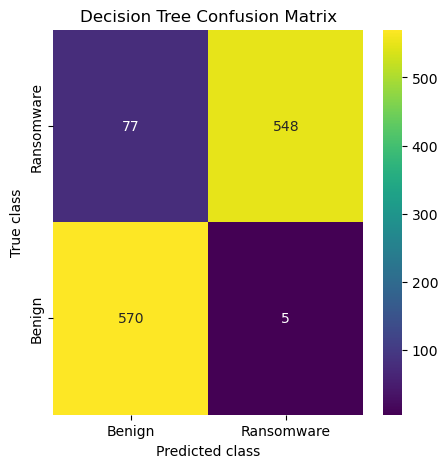

In [59]:
X_train_flat = X_train.values.reshape(X_train.shape[0], -1)
X_test_flat = X_test.values.reshape(X_test.shape[0], -1)

# Train the Decision Tree classifier with hyperparameters
dt_cls = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=2, max_features="sqrt")
dt_cls.fit(X_train_flat, y_train)

# Predict and evaluate
predict = dt_cls.predict(X_test_flat)
calculateMetrics("Decision Tree", predict, y_test)

In [36]:
dt_acc = accuracy_score(predict, y_test)
dt_prec = precision_score(predict, y_test,average='macro')
dt_rec = recall_score(predict, y_test,average='macro')
dt_f1 = f1_score(predict, y_test,average='macro')

storeResults('Decision Tree',dt_acc,dt_prec,dt_rec,dt_f1)

# Random Forest


Random Forest Accuracy  : 93.16666666666666
Random Forest Precision : 93.59737947572745
Random Forest Recall    : 93.40521739130435
Random Forest F1 Score  : 93.16436913518154


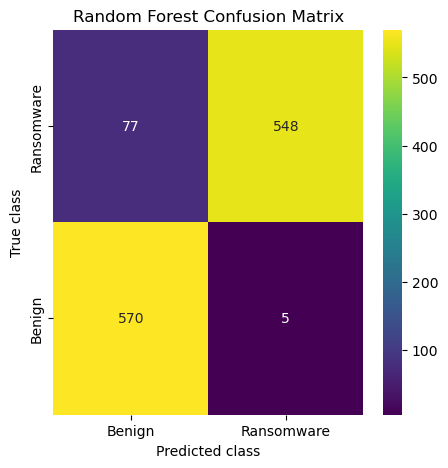

In [60]:
#training random Forest algortihm
rf = RandomForestClassifier(n_estimators=40, criterion='gini', max_features="log2", min_weight_fraction_leaf=0.3)
rf.fit(X_train, y_train)
predict = rf.predict(X_test)
calculateMetrics("Random Forest", predict, y_test)

In [61]:
rf_acc = accuracy_score(predict, y_test)
rf_prec = precision_score(predict, y_test,average='macro')
rf_rec = recall_score(predict, y_test,average='macro')
rf_f1 = f1_score(predict, y_test,average='macro')

storeResults('Random Froest',rf_acc,rf_prec,rf_rec,rf_f1)

# XGBoost


XGBoost Accuracy  : 98.75
XGBoost Precision : 98.81385334508417
XGBoost Recall    : 98.70260869565217
XGBoost F1 Score  : 98.74654516511134


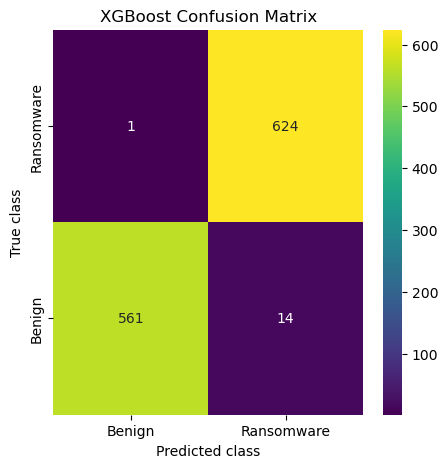

In [62]:
#now train XGBoost algorithm
xgb_model = XGBClassifier(n_estimators=10, learning_rate=0.09, max_depth=2)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
calculateMetrics("XGBoost", xgb_predictions, y_test)

In [63]:
rf_acc = accuracy_score(predict, y_test)
rf_prec = precision_score(predict, y_test,average='macro')
rf_rec = recall_score(predict, y_test,average='macro')
rf_f1 = f1_score(predict, y_test,average='macro')

storeResults('XGBoost',rf_acc,rf_prec,rf_rec,rf_f1)

# Voting Classifier


Voting Classifier Accuracy  : 99.5
Voting Classifier Precision : 99.4928659057337
Voting Classifier Recall    : 99.50608695652174
Voting Classifier F1 Score  : 99.49919871794873


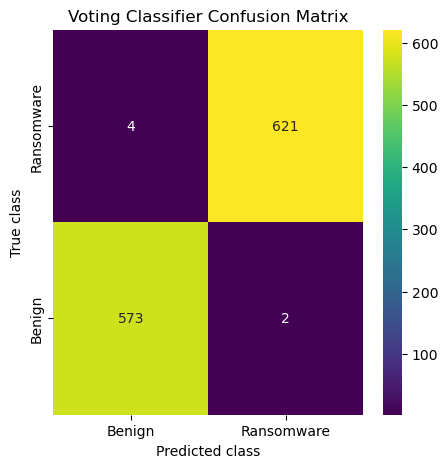

In [65]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
import joblib

# Define individual models
ada_model = AdaBoostClassifier(n_estimators=10, random_state=0)
rf_model = RandomForestClassifier(n_estimators=5, random_state=1)

# Create the soft voting classifier
voting_model = VotingClassifier(
    estimators=[('adaboost', ada_model), ('randomforest', rf_model)],
    voting='soft'
)

# Train the ensemble model
voting_model.fit(X_train, y_train)

# Make predictions
voting_predictions = voting_model.predict(X_test)

# Evaluate
calculateMetrics("Voting Classifier", voting_predictions, y_test)

# Save the trained model



In [66]:
rf_acc = accuracy_score(predict, y_test)
rf_prec = precision_score(predict, y_test,average='macro')
rf_rec = recall_score(predict, y_test,average='macro')
rf_f1 = f1_score(predict, y_test,average='macro')

storeResults('Voting Classifier',rf_acc,rf_prec,rf_rec,rf_f1)

# DNN

In [68]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Create the DNN model
dnn_model = Sequential()
dnn_model.add(Dense(2, input_shape=(X_train.shape[1],), activation='relu'))
dnn_model.add(Dense(2, activation='relu'))
dnn_model.add(Dropout(0.3))
dnn_model.add(Dense(y_train_cat.shape[1], activation='softmax'))

# Compile the model
dnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define model save path
weights_path = "models/dnn_weights.keras"  # <-- changed extension to .keras
history_path = "models/dnn_history.pckl"

# Create 'models' directory if not exists
os.makedirs("models", exist_ok=True)

# Train the model if weights do not exist
if not os.path.exists(weights_path):
    checkpoint = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)
    history = dnn_model.fit(
        X_train, y_train_cat,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test_cat),
        callbacks=[checkpoint],
        verbose=1
    )
    # Save training history (optional)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
else:
    dnn_model.load_weights(weights_path)



Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4480 - loss: 31701624.0000
Epoch 1: val_loss improved from inf to 15833327.00000, saving model to models/dnn_weights.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4480 - loss: 31663998.0000 - val_accuracy: 0.4800 - val_loss: 15833327.0000
Epoch 2/10
142/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4533 - loss: 12785324.0000
Epoch 2: val_loss improved from 15833327.00000 to 6149876.00000, saving model to models/dnn_weights.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4530 - loss: 12642883.0000 - val_accuracy: 0.4867 - val_loss: 6149876.0000
Epoch 3/10
147/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4615 - loss: 5216314.5000
Epoch 3: val_loss improved from 6149876.00000 to 2182505.75000, saving model to models/dnn_weights.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4615 - loss: 5180961.5000 - val_accuracy: 0.4983 - val_loss: 2182505.7500
Epoch 4/10
150/150 ━━━━━━

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

DNN Accuracy  : 77.83333333333333
DNN Precision : 79.21876213403742
DNN Recall    : 78.26782608695653
DNN F1 Score  : 77.71889510290353


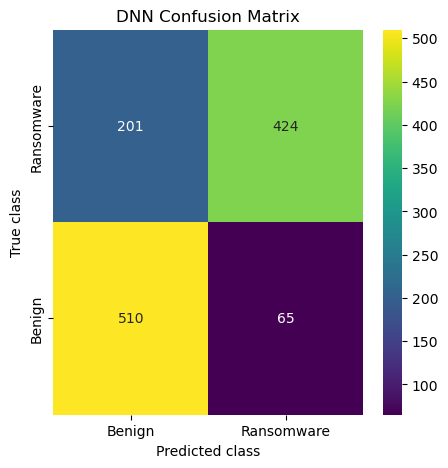

In [69]:
predict = dnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("DNN", predict, testY)#call function to calculate accuracy and other metrics

In [45]:
rf_acc = accuracy_score(predict, testY)
rf_prec = precision_score(predict, testY,average='macro')
rf_rec = recall_score(predict, testY,average='macro')
rf_f1 = f1_score(predict, testY,average='macro')

storeResults('DNN',rf_acc,rf_prec,rf_rec,rf_f1)

# LSTM

In [70]:
#now train LSTM algorithm
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [71]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(X_train1.shape[1], X_train1.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(y_train1.shape[1], activation='softmax'))

# Compile model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define file paths
weights_path = "models/lstm_weights.keras"
history_path = "models/lstm_history.pckl"
os.makedirs("models", exist_ok=True)

# Train or load the model
if not os.path.exists(weights_path):
    checkpoint = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)
    history = lstm_model.fit(
        X_train1, y_train1,
        batch_size=32,
        epochs=10,
        validation_data=(X_test1, y_test1),
        callbacks=[checkpoint],
        verbose=1
    )
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
else:
    lstm_model.load_weights(weights_path)

# Now you can use the trained model for prediction
pred = lstm_model.predict(X_test1)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8598 - loss: 0.4608
Epoch 1: val_loss improved from inf to 0.18436, saving model to models/lstm_weights.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8601 - loss: 0.4598 - val_accuracy: 0.9233 - val_loss: 0.1844
Epoch 2/10
146/150 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9348 - loss: 0.1796
Epoch 2: val_loss improved from 0.18436 to 0.17207, saving model to models/lstm_weights.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9352 - loss: 0.1790 - val_accuracy: 0.9450 - val_loss: 0.1721
Epoch 3/10
144/150 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9500 - loss: 0.1530
Epoch 3: val_loss improved from 0.17207 to 0.17170, saving model to models/lstm_weights.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9501 - loss: 0.1529 - val_accuracy: 0.9408 - val_loss: 0.1717
Epoch 4/10
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9534 - loss: 0.1455
Epoch 4: val_loss improve

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

LSTM Accuracy  : 94.75
LSTM Precision : 94.80959050286782
LSTM Recall    : 94.86956521739131
LSTM F1 Score  : 94.74938378184662


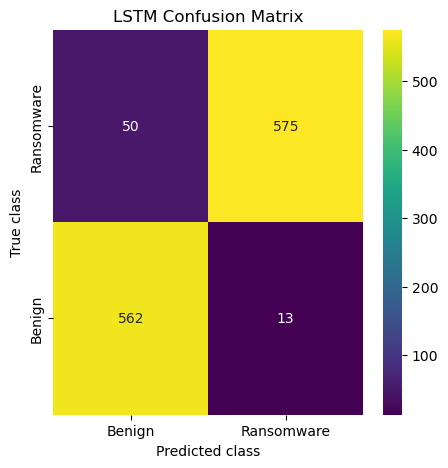

In [48]:
predict = lstm_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("LSTM", predict, testY)#call function to calculate accuracy and other metrics

In [72]:
rf_acc = accuracy_score(predict, testY)
rf_prec = precision_score(predict, testY,average='macro')
rf_rec = recall_score(predict, testY,average='macro')
rf_f1 = f1_score(predict, testY,average='macro')

storeResults('LSTM',rf_acc,rf_prec,rf_rec,rf_f1)

# CNN

In [73]:
#now train extension CNN algorithm
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))

In [51]:

#define extension CNN model object
cnn_model = Sequential()
#adding CNN layer wit 32 filters to optimized dataset features using 32 neurons
cnn_model.add(Convolution2D(64, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
#adding maxpooling layer to collect filtered relevant features from previous CNN layer
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#adding another CNN layer to further filtered features
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#collect relevant filtered features
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
#defining output layers
cnn_model.add(Dense(units = 256, activation = 'relu'))
#defining prediction layer with Y target data
cnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compile the CNN with LSTM model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train and load the model
#if os.path.exists("model/cnn_weights.hdf5") == False:
   # model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
hist = cnn_model.fit(X_train1, y_train1, batch_size = 8, epochs = 10, validation_data=(X_test1, y_test1), verbose=1)
   # f = open('model/cnn_history.pckl', 'wb')
   # pickle.dump(hist.history, f)
   # f.close()    
#else:
    #cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data        

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8987 - loss: 117758.9688 - val_accuracy: 0.9583 - val_loss: 5301.2129
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9451 - loss: 3776.6772 - val_accuracy: 0.9317 - val_loss: 0.1988
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9355 - loss: 0.1834 - val_accuracy: 0.9317 - val_loss: 0.1767
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9388 - loss: 0.1721 - val_accuracy: 0.9317 - val_loss: 0.1795
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9442 - loss: 0.1628 - val_accuracy: 0.9433 - val_loss: 0.1614
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9399 - loss: 0.1742 - val_accuracy: 0.9467 - val_loss: 0.1667
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9454 - loss: 0.1615 - val_accuracy: 0.9483 - val_loss: 0.1635
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9531 - loss: 0.1416 - val

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Extension CNN2D Accuracy  : 94.83333333333334
Extension CNN2D Precision : 94.96132762634227
Extension CNN2D Recall    : 94.98434782608696
Extension CNN2D F1 Score  : 94.83327592528806


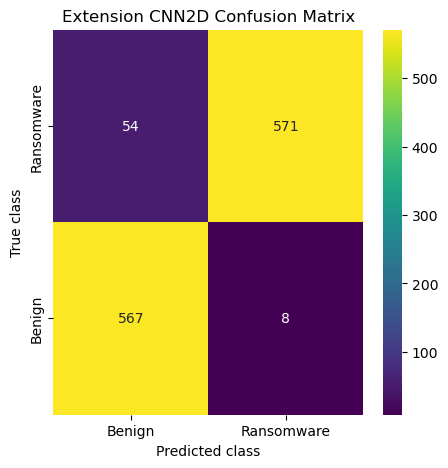

In [74]:
predict = cnn_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("Extension CNN2D", predict, testY)#call function to calculate accuracy and other metrics

In [75]:
rf_acc = accuracy_score(predict, testY)
rf_prec = precision_score(predict, testY,average='macro')
rf_rec = recall_score(predict, testY,average='macro')
rf_f1 = f1_score(predict, testY,average='macro')

storeResults('Extension CNN2D',rf_acc,rf_prec,rf_rec,rf_f1)

# Comparison

In [76]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : acc,
                       'Precision': prec,
                       'Recall'   : rec,
                        'f1_score' : f1,
                      })

In [ ]:
result

# Modelling

In [1]:
import joblib

# Save sklearn models
joblib.dump(rf_model, 'models/randomforest.pkl')
joblib.dump(svm_cls, 'models/svm.pkl')
joblib.dump(xgb_model, 'models/xgboost.pkl')
joblib.dump(dt_cls, 'models/decisiontree.pkl')
joblib.dump(voting_model, 'models/voting.pkl')
# Save keras models in the recommended .keras format
lstm_model.save('models/lstm.keras')
dnn_model.save('models/dnn.keras')
cnn_model.save('models/cnn.keras')



NameError: name 'rf_model' is not defined

# Graph

In [82]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

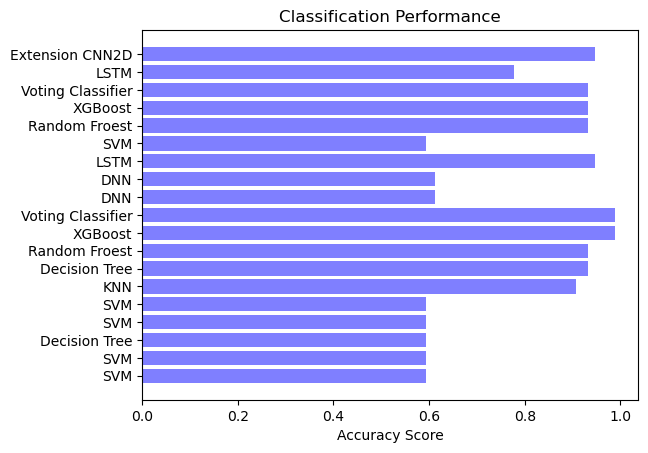

In [83]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, acc, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

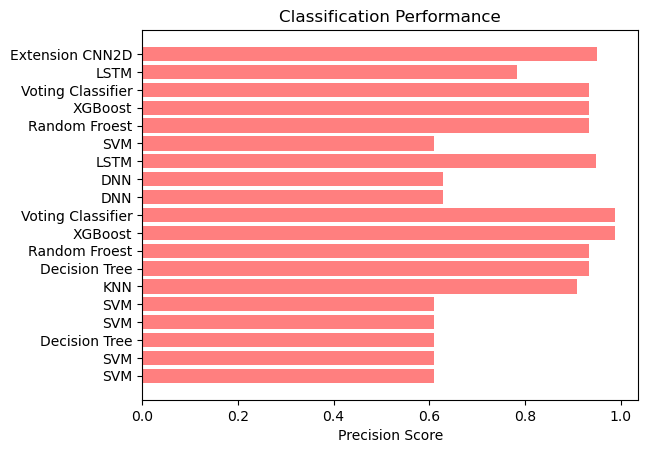

In [84]:
plt2.barh(y_pos, prec, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

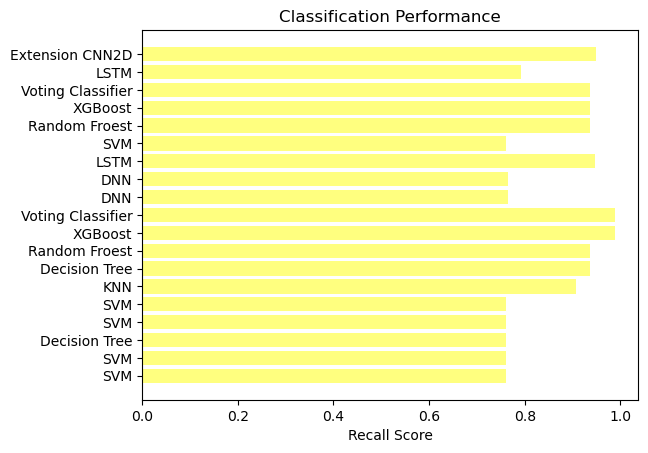

In [85]:
plt2.barh(y_pos, rec, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

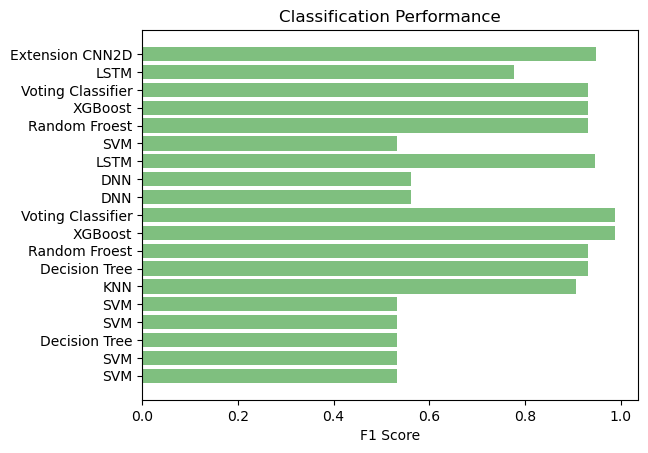

In [86]:
plt2.barh(y_pos, f1, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()